# Stack and Test Models

In [1]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

plt.style.use('ggplot')

We load the test set

In [2]:
# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))
numerical = list(set(numerical)-set(['SalePrice']))

df.shape

(1459, 278)

In the train set we noticed that some variables seem to be entered by mistake or represent a very unusual property (i.e. 5000 sq feet garage). We impute the values that differ from the mean by more than 5 standard deviation with the mean.

In [3]:
X=df.copy()

## Predictions using linear models

Load models

In [4]:
models_comb = pickle.load(open('./tmp/models_comb', 'rb'))
models_comb

,model,score
0,model1a,0.100879
1,model1b,0.098294
2,model2a,0.110401
3,model2b,0.110007


### All variables

Linear regression with ridge regularization

In [5]:
model1a = pickle.load(open('./tmp/model1a.model', 'rb'))
model1a

Ridge(alpha=array([6.]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [6]:
a1 = np.exp(model1a.predict(X))
a1.shape

(1459,)

Linear regression with LASSO regularization

In [7]:
model1b = pickle.load(open('./tmp/model1b.model', 'rb'))
model1b

Lasso(alpha=0.00015000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
b1 = np.exp(model1b.predict(X))
b1.shape

(1459,)

### Selected variables

Load selected variables

In [9]:
selected = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))
selected

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 'CentralAir_Y',
 '1stFlrSF',
 'BsmtFinSF1',
 'GarageCars',
 'OverallCond',
 'GarageYrBlt',
 'LotFrontage',
 'YearBuilt',
 'LotArea',
 'YearRemodAdd',
 'MSZoning_RM',
 '2ndFlrSF',
 'Neighborhood_IDOTRR',
 'GarageType_Detchd',
 'BsmtUnfSF',
 'MasVnrArea',
 'FullBath',
 'WoodDeckSF',
 'FireplaceQu_No',
 'GarageQual_TA',
 'MSSubClass_60',
 'DJREI',
 'Fannie',
 'TotRmsAbvGrd',
 'MoSold',
 'GarageType_Attchd',
 'Fence_GdWo',
 'LaborForce',
 'Corn',
 'LotShape_Reg',
 'OpenPorchSF',
 'EnclosedPorch',
 'GarageFinish_Unf',
 'HouseStyle_2Story',
 'KitchenQual_Gd',
 'Month',
 'KitchenAbvGr',
 'KitchenQual_TA',
 'UnemplRate',
 'Fireplaces',
 'Neighborhood_NAmes',
 'MasVnrType_None',
 'HeatingQC_TA',
 'BsmtQual_Gd',
 'MSSubClass_50',
 'ExterQual_TA',
 'BsmtFinType1_Rec',
 'SaleCondition_Normal',
 'HalfBath',
 'MSZoning_RL',
 'BsmtFinType1_No',
 'BedroomAbvGr',
 'RoofStyle_Hip',
 'ExterCond_Fa',
 'FireplaceQu_TA',
 'PavedDrive_Y',
 'Functi

In [10]:
X_sel = X[selected]
X_sel.shape

(1459, 137)

Linear regression with ridge regularization

In [11]:
model2a = pickle.load(open('./tmp/model2a.model', 'rb'))
model2a

Ridge(alpha=array([5.43442]), copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [12]:
a2 = np.exp(model2a.predict(X_sel))
a2.shape

(1459,)

Linear regression with LASSO regularization

In [13]:
model2b = pickle.load(open('./tmp/model2b.model', 'rb'))
model2b

Lasso(alpha=0.00015000000000000001, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [14]:
b2 = np.exp(model2b.predict(X_sel))
b2.shape

(1459,)

## TreeRegressor

In [15]:
tree = pickle.load(open('./tmp/tree.model', 'rb'))
tree

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
tr = np.exp(tree.predict(X))
tr.shape

(1459,)

## XGB

In [17]:
xgb_mod = pickle.load(open('./tmp/xgb_mod.model', 'rb'))
xgb_mod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=nan, n_estimators=30,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [18]:
gb = np.exp(xgb_mod.predict(X))
gb.shape

(1459,)

## Combining 

Let's comnine all predictions

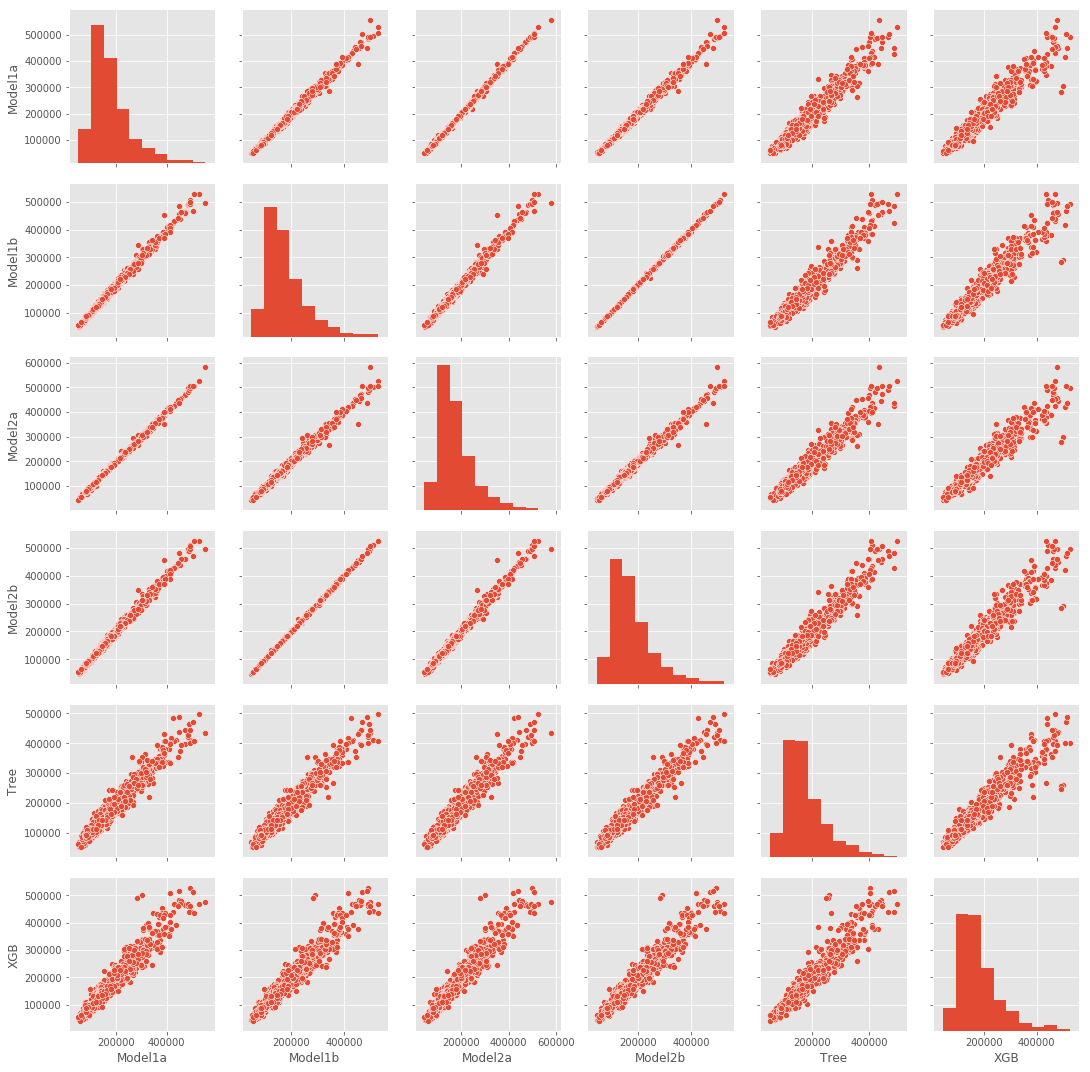

In [19]:
predictions = pd.DataFrame([a1, a2, b1, b2, tr, gb]).T
predictions.columns = ['Model1a', 'Model1b', 'Model2a', 'Model2b', 'Tree', 'XGB']
sns.pairplot(predictions)

Weighting the predictions.

Use SuperLearner

In [20]:
# Load SuperLearner

# superLearner = pickle.load(open('./tmp/superDT.model', 'rb'))


# prediction = superLearner.predict(predictions)
# prediction.shape

In [21]:
#Load all models results
tree_comb = pickle.load(open('./tmp/tree_comb', 'rb'))

models = models_comb.append(tree_comb).reset_index().drop('index', axis=1)
models

#Calculate weights
sm = np.sum(1/models['score'])
models['wght'] = models.score.apply(lambda x: (1/x) / sm) 

# Apply weights to predictions
weights = np.array(models['wght']).T
#weights = np.array([0.20, 0.20, 0.20, 0.20, 0, 0, 0.2]).T
pred_mat = np.matrix(predictions)

prediction = weights.dot(pred_mat.T)
prediction.shape

(1, 1459)

In [22]:
prediction

matrix([[118461.07653369, 152754.22092246, 183208.59661542, ...,
         173517.32011292, 116817.50157064, 224191.76851957]])

In [23]:
prediction = np.array(prediction)
prediction

array([[118461.07653369, 152754.22092246, 183208.59661542, ...,
        173517.32011292, 116817.50157064, 224191.76851957]])

In [25]:
# Create a dataframe

# Load the test set
df = pd.read_csv('./data/new_test.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#Reshape prediction

submission = pd.DataFrame({'Id':df['Id'], 'Predicted': prediction[0,:]})

submission.head()


,Id,Predicted
0,1461,118461.076534
1,1462,152754.220922
2,1463,183208.596615
3,1464,196529.737394
4,1465,196301.309138


## Use real data

We find the answer key in R package https://cran.r-project.org/web/packages/AmesHousing/index.html

In [26]:
# Load answer key
answer = pd.read_csv('./data/answerkey.csv', index_col=0)
answer.head()

,Id,SalePrice
0,1461,105000
1,1462,172000
2,1463,189900
3,1464,195500
4,1465,191500


In [27]:
# Merge with prediction

result = pd.merge(answer, submission, on='Id', how='left')
result.head()

,Id,SalePrice,Predicted
0,1461,105000,118461.076534
1,1462,172000,152754.220922
2,1463,189900,183208.596615
3,1464,195500,196529.737394
4,1465,191500,196301.309138


We greaphically analyze our predictions

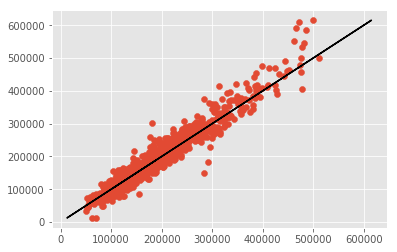

In [28]:
#Plot 

plt.scatter(result['Predicted'], result['SalePrice'])
plt.plot(result['SalePrice'], result['SalePrice'], c='black')

We calculate RMSLE using natural logarithm of prices

In [29]:
rmsle = np.sqrt(np.mean((np.log(result['SalePrice']) - np.log(result['Predicted']))**2))
rmsle

0.12070136030788897

... and the logarithm with base 10.

In [30]:
rmsle10 = np.sqrt(np.mean((np.log10(result['SalePrice']) - np.log10(result['Predicted']))**2))
rmsle10

0.052419934739932325

In [31]:
def rmsl_test(x,y):
    return (np.sqrt(np.mean((np.log(x)-np.log(y))**2)))

tmp_= result.join(predictions)

for i in range(2,9):
    y = tmp_.SalePrice
    x = tmp_.iloc[:,i]
    
    print(tmp_.columns.values[i], ":", rmsl_test(x,y))

Predicted : 0.12070136030788897
Model1a : 0.1203081555946344
Model1b : 0.12334737982583391
Model2a : 0.1218646253710037
Model2b : 0.12277118489523224
Tree : 0.14862195262422853
XGB : 0.1574086908742302
